<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## GeostatsPy Well-documented Demonstration Workflows 

### Spatial Data Declustering for Representative Statistics with all Methods

#### Michael Pyrcz, Professor, The University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

This is a tutorial for / demonstration of **Spatial Data Declustering**. 

**YouTube Lecture**: check out my lecture on [Sources of Spatial Bias](https://youtu.be/w0HgVibxpMQ?si=8sOBf4sUIRqfvOc7) and [Spatial Data Declustering](https://youtu.be/rN0RKcTIVcI?si=6EOJvDKEplGtkXKD). The methods demonstrated here include:

* cell-based declustering
* polygonal declustering
* kriging-based declustering

#### Geostatistical Sampling Representativity

In general, we should assume that all spatial data that we work with is sampled in a biased manner. Why? ...

##### Source of Spatial Sampling Bias

Data is collected to answer questions:
* how far does the contaminant plume extend? – sample peripheries
* where is the fault? – drill based on seismic interpretation
* what is the highest mineral grade? – sample the best part
* who far does the reservoir extend? – offset drilling
and to maximize NPV directly:
* maximize production rates

**Random Sampling**: when every item in the population has a equal chance of being chosen. Selection of every item is independent of every other selection.
Is random sampling sufficient for subsurface?  Is it available?
* it is not usually available, would not be economic
* data is collected answer questions
    * how large is the reservoir, what is the thickest part of the reservoir 
* and wells are located to maximize future production
    * dual purpose appraisal and injection / production wells!

**Regular Sampling**: when samples are taken at regular intervals (equally spaced).  
* less reliable than random sampling.
* Warning: may resonate with some unsuspected environmental variable.

What do we have?
* we usually have biased, opportunity sampling 
* we must account for bias (debiasing will be discussed later)

So if we were designing sampling for representativity of the sample set and resulting sample statistics, by theory we have 2 options, random sampling and regular sampling.

* What would happen if you proposed random sampling in the Gulf of Mexico at $150M per well?

We should not change current sampling methods as they result in best economics, we should address sampling bias in the data.

Never use raw spatial data without access sampling bias / correcting.

#### Mitigating Sampling Bias

Here's a summary of all the methods:

##### Cell-based Declustering

Place a cell mesh over the data and share the weight over each cell. Data in densely sampled areas or volumes will get less weight while data in sparsely sampled areas or volumes will get more weight.

Cell-based declustering weights are calculated by first identifying the cell that the data occupies, $\ell$, then,

\begin{equation}
w(\bf{𝐮}_j) = \frac{1}{n_{\ell}} \cdot \frac{n}{L_o}
\end{equation}

where $n_{\ell}$ is the number of data in the $\ell$ cell standardized by the ratio of $n$ is the total number of data divided by $L_o$ number of cells with data. As a result the sum of all weights is $n$ and nominal weight is 1.0. 

Additional considerations:

* influence of cell mesh origin is removed by averaging the data weights over multiple random cell mesh origins
* the optimum cell size is selected by minimizing or maximizing the declustered mean, based on whether the means is biased high or low respectively

In this demonstration we will take a biased spatial sample data set and apply declustering using **GeostatsPy** functionality. 

##### Polygonal-based Declustering

Assign Voronoi poloygons to the data within the area or volume of interest. Then apply data weights proportional to the area or volume of the associated Voronoi polygon and standardized by the totol area or volume.

\begin{equation}
w(\bf{𝐮}_j) = \frac{a_j}{A} \cdot n
\end{equation}

Additional considerations:

* this method is very sensitive to the area or volume boundary

##### Kriging-based Declustering

Assign a grid over the area or volume of interest and perform kriging. While performing kriging, sum the weight assigned to each data over all the grid cells. Assign declustering weights as the sum of kriging weights standardized by the total number of data divided by the total kriging weight over all data and grid cells. 

\begin{equation}
w(\bf{𝐮}_j) = \sum_{i_y = 1}^{n_y} \sum_{i_x = 1}^{n_x} \lambda_{j,ix,iy} \cdot \frac{n}{\sum \lambda}
\end{equation}

Additional considerations:

* this method is sensitive to the grid extends and integrates the concept of spatial continuity through the variogram.
* high resolution grids will increase accuracy but takes longer to calculate 

#### Load the required libraries

The following code loads the required libraries.

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python  
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))

GeostatsPy version: 0.0.52


We will also need some standard packages. These should have been installed with Anaconda 3.

In [29]:
ignore_warnings = True                                        # ignore warnings?
import geostatspy.GSLIB as GSLIB                              # GSLIB utilies, visualization and wrapper
import numpy as np                                            # ndarrys for gridded data
import pandas as pd                                           # DataFrames for tabular data
import os                                                     # set working directory, run executables
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
import matplotlib.ticker as mtick                             # control tick label formatting
from scipy import stats                                       # summary statistics
import numpy.linalg as linalg                                 # for linear algebra
import scipy.spatial as sp                                    # for fast nearest neighbor search
from numba import jit                                         # for numerical speed up
from statsmodels.stats.weightstats import DescrStatsW
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')

#### Declare functions

These are some of the functions from GeostatsPy required by the new program.  We will declare them here and then in the future integrate the new indicator kriging program into the package properly.

In [3]:
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks   

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [4]:
#os.chdir("c:/PGE383")                                        # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

In [5]:
df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_biased.csv') # load data

We can preview the DataFrame by:

* printing a slice or by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). With the slice we could look at any subset of the data table. 

* head function with 1 parameter, the number of samples or data table rows to include, e.g., 'n=3' to see the first 3 rows of the dataset.  

In [6]:
#print(df.iloc[0:5,:])                                        # display first 4 samples in the table as a preview
df.head(n=3)                                                  # we could also use this command for a table preview

,X,Y,Facies,Porosity,Perm
0,100,900,1,0.115359,5.736104
1,100,800,1,0.136425,17.211462
2,100,600,1,0.135810,43.724752


#### Summary Statistics for Tabular Data

The table includes X and Y coordinates (meters), Facies 1 and 2 (1 is sandstone and 0 interbedded sand and mudstone), Porosity (fraction), and permeability as Perm (mDarcy). 

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [7]:
df.describe().transpose()                                     # summary statistics

,count,mean,std,min,25%,50%,75%,max
X,289.0,475.813149,254.277530,0.000000,300.000000,430.000000,670.000000,990.000000
Y,289.0,529.692042,300.895374,9.000000,269.000000,549.000000,819.000000,999.000000
Facies,289.0,0.813149,0.390468,0.000000,1.000000,1.000000,1.000000,1.000000
Porosity,289.0,0.134744,0.037745,0.058548,0.106318,0.126167,0.154220,0.228790
Perm,289.0,207.832368,559.359350,0.075819,3.634086,14.908970,71.454424,5308.842566


#### Specify the Area of Interest

It is natural to set the x and y coordinate and feature ranges manually. e.g. do you want your color bar to go from 0.05887 to 0.24230 exactly? Also, let's pick a color map for display. I heard that plasma is known to be friendly to the color blind as the color and intensity vary together (hope I got that right, it was an interesting Twitter conversation started by Matt Hall from Agile if I recall correctly). We will assume a study area of 0 to 1,000m in x and y and omit any data outside this area.

In [8]:
xmin = 0.0; xmax = 1000.0                                     # range of x values
ymin = 0.0; ymax = 1000.0                                     # range of y values
pormin = 0.05; pormax = 0.2                                   # range of porosity values
cmap = plt.cm.inferno                                         # color map

Visualizing Tabular Data with Location Maps¶ 
Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib. I hope you find it simpler than matplotlib, if you want to get more advanced and build custom plots lock at the source. If you improve it, send me the new code. Any help is appreciated. To see the parameters, just type the command name:

In [9]:
GSLIB.locmap                                                  # GeostatsPy's 2D point plot function

<function geostatspy.GSLIB.locmap(df, xcol, ycol, vcol, xmin, xmax, ymin, ymax, vmin, vmax, title, xlabel, ylabel, vlabel, cmap, fig_name)>

Now we can populate the plotting parameters and visualize the porosity data.

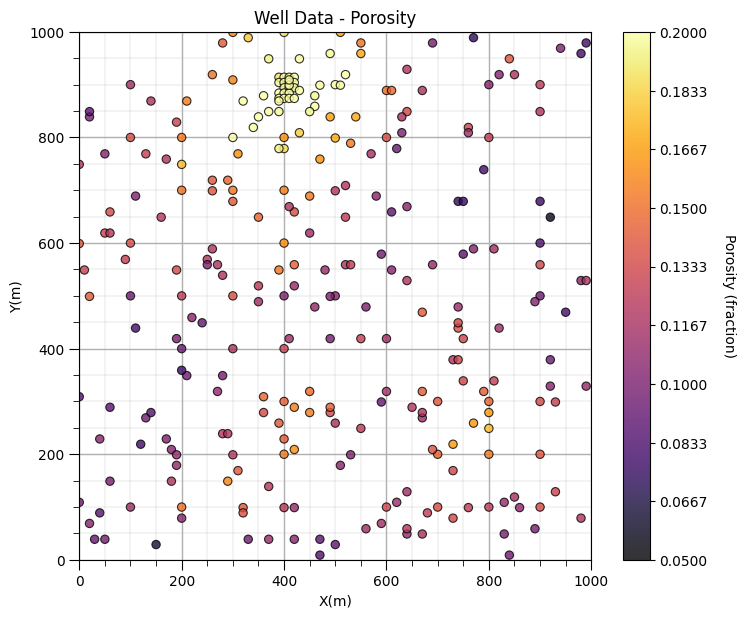

In [10]:
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap); add_grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Look carefully, and you'll notice the the spatial samples are more dense in the high porosity regions and lower in the low porosity regions.  There is preferential sampling.  We cannot use the naive statistics to represent this region.  We have to correct for the clustering of the samples in the high porosity regions. 

### Cell-based Declustering

Let's try cell declustering. We can interpret that we will want to minimize the declustering mean and that a cell size of between 100 - 200m is likely a good cell size, this is 'an ocular' estimate of the largest average spacing in the sparsely sampled regions.   

Let's check out the declus program reimplimented from GSLIB.

In [11]:
geostats.declus                                               # GeostatsPy's cell-based declustering function

<function geostatspy.geostats.declus(df, xcol, ycol, vcol, iminmax, noff, ncell, cmin, cmax)>

We can now populate the parameters. The parameters are:

* **df** - DataFrame with the spatial dataset
* **xcol** - column with the x coordinate
* **ycol** - column with the y coordinate
* **vcol** - column with the feature value
* **iminmax** - if 1 use the cell size that minimizes the declustered mean, if 0 the cell size that maximizes the declustered mean
* **noff** - number of cell mesh offsets to average the declustered weights over
* **ncell** - number of cell sizes to consider (between the **cmin** and **cmax**)
* **cmin** - minimum cell size
* **cmax** - maximum cell size

We will run a very wide range of cell sizes, from 10m to 2,000m ('cmin' and 'cmax') and take the cell size that minimizes the declustered mean ('iminmax' = 1 minimize, and = 0 maximize). Multiple offsets (number of these is 'noff') uses multiple grid origins and averages the results to remove sensitivity to grid position.  The ncell is the number of cell sizes.

The output from this program is:

* **wts** - an array with the weigths for each data (they sum to the number of data, 1 indicates nominal weight)
* **cell_sizes** - an array with the considered cell sizes
* **dmeans** - an array with the declustered mean for each of the **cell_sizes**

The **wts** are the declustering weights for the selected (minimizing or maximizing cell size) and the **cell_sizes** and **dmeans** are plotted to build the diagnostic declustered mean vs. cell size plot (see below).

In [13]:
ncell = 100; cmin = 1; cmax = 5000; noff = 10; iminmax = 1    # cell-based declustering parameters

wts_cell, cell_sizes, dmeans_cell = geostats.declus(df,'X','Y','Porosity',iminmax = iminmax,noff = noff,
        ncell = ncell,cmin = cmin,cmax = cmax)                # GeostatsPy's declustering function
df['Wts_cell'] = wts_cell                                     # add weights to the sample data DataFrame
df.head()                                                     # preview to check the sample data DataFrame

There are 289 data with:
   mean of      0.13474387540138408 
   min and max  0.058547873 and 0.228790002
   standard dev 0.03767982164385208 


,X,Y,Facies,Porosity,Perm,Wts_cell
0,100,900,1,0.115359,5.736104,3.423397
1,100,800,1,0.136425,17.211462,1.254062
2,100,600,1,0.135810,43.724752,1.037802
3,100,500,0,0.094414,1.609942,1.112225
4,100,100,0,0.113049,10.886001,1.176394


Let's look at the location map of the weights.

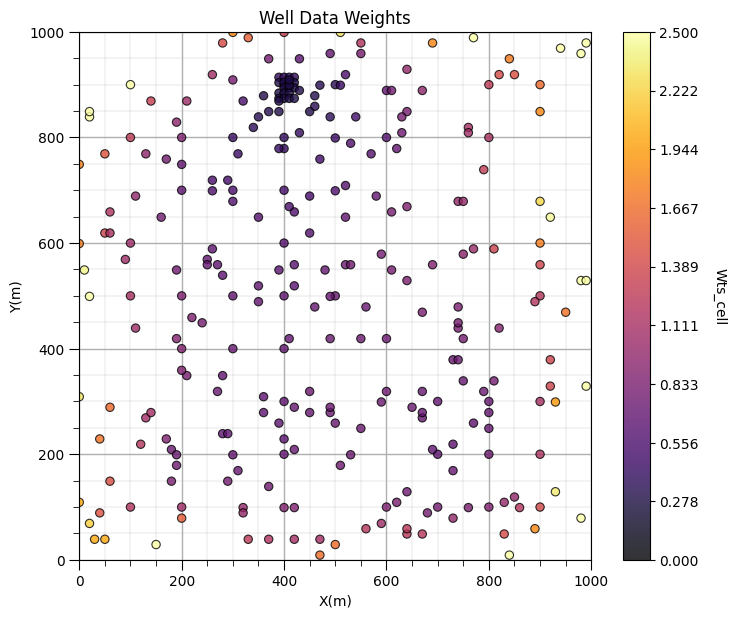

In [14]:
GSLIB.locmap_st(df,'X','Y','Wts_cell',xmin,xmax,ymin,ymax,0.0,2.5,'Well Data Weights','X(m)','Y(m)','Wts_cell',cmap); add_grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Does it look correct?  See the weight varies with local sampling density?  

Now let's add the distribution of the weights and the naive and declustered porosity distributions. You should see the histogram bars adjusted by the weights. Also note the change in the mean due to the weights. There is a significant change.

Porosity naive mean is 0.135.
Porosity declustered mean is 0.122.
Correction of 0.098.

Summary statistics of the declustering weights:
DescribeResult(nobs=289, minmax=(0.29697647801768134, 4.929726774433297), mean=1.0000000000000002, variance=0.4891880890588495, skewness=2.42705727031815, kurtosis=7.382471118201144)


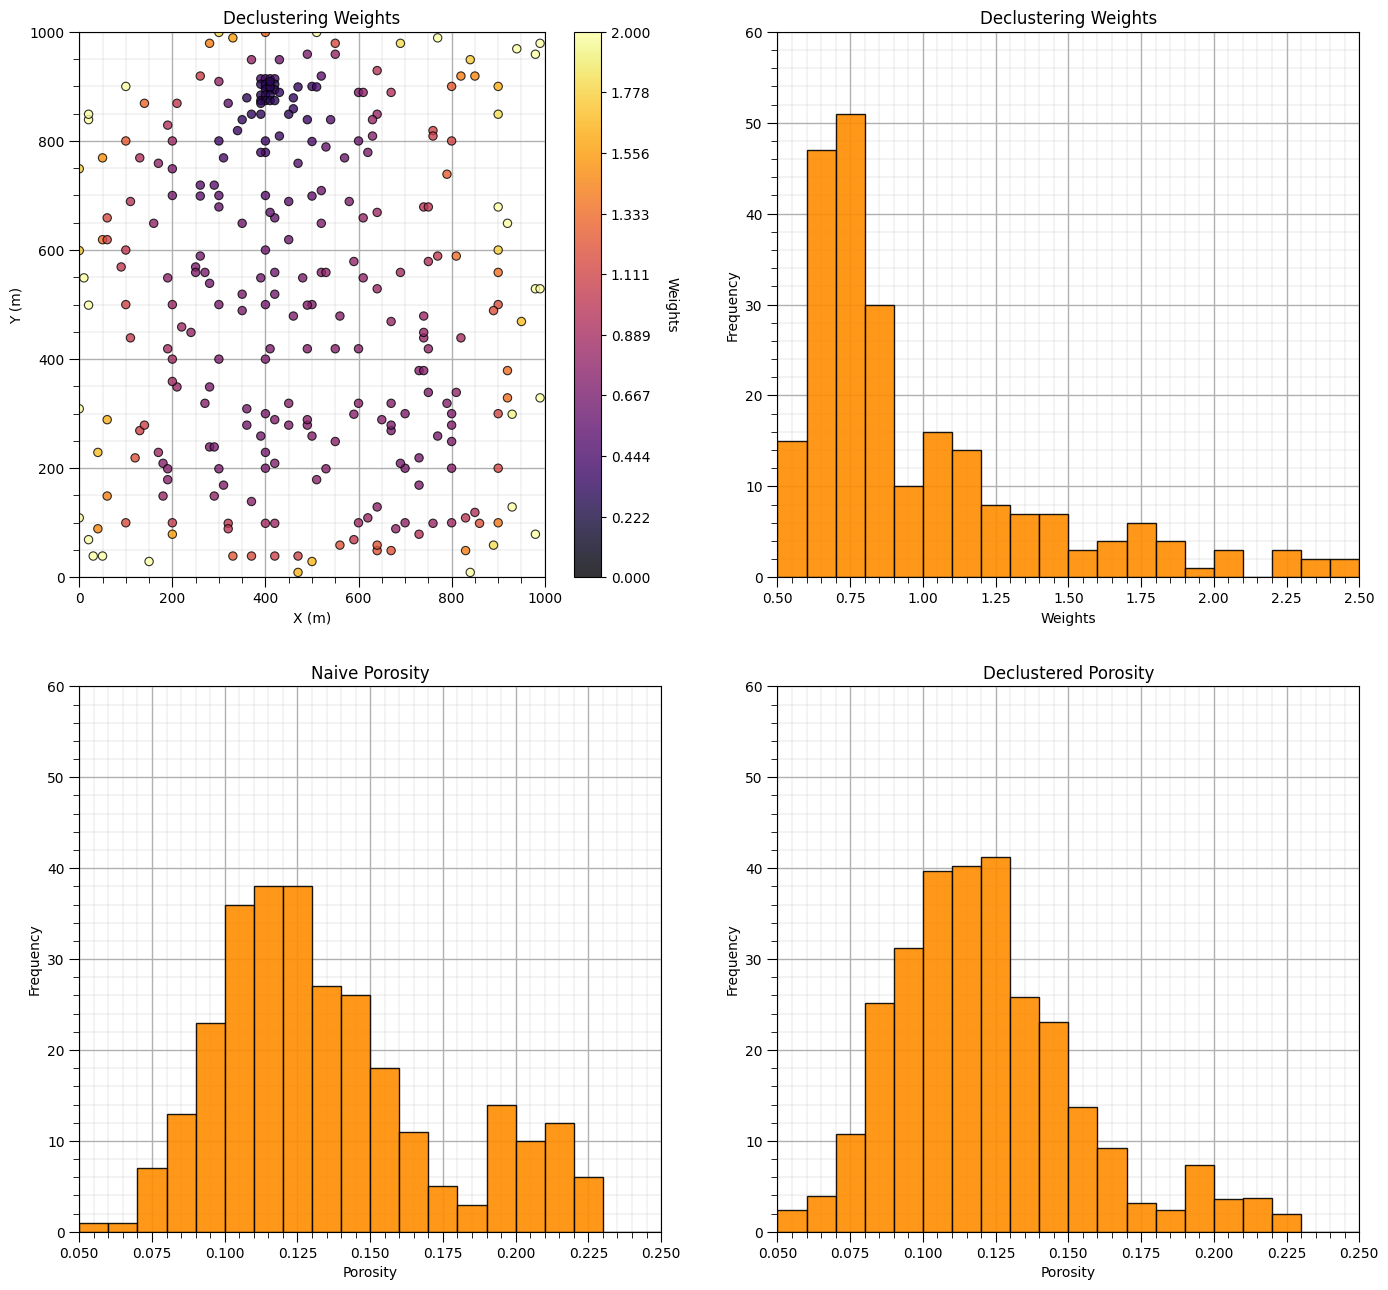

In [15]:
plt.subplot(221)
GSLIB.locmap_st(df,'X','Y','Wts_cell',xmin,xmax,ymin,ymax,0.0,2.0,'Declustering Weights','X (m)','Y (m)','Weights',cmap); add_grid()

plt.subplot(222)
GSLIB.hist_st(df['Wts_cell'],0.5,2.5,log=False,cumul=False,bins=20,weights=None,xlabel="Weights",title="Declustering Weights"); add_grid()
plt.ylim(0.0,60)

plt.subplot(223)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity",title="Naive Porosity"); add_grid()
plt.ylim(0.0,60)

plt.subplot(224)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=df['Wts_cell'],xlabel="Porosity",title="Declustered Porosity"); add_grid()
plt.ylim(0.0,60)

por_mean = np.average(df['Porosity'].values)
por_dmean_cell = np.average(df['Porosity'].values,weights=df['Wts_cell'].values)

print('Porosity naive mean is ' + str(round(por_mean,3))+'.')
print('Porosity declustered mean is ' + str(round(por_dmean_cell,3))+'.')
cor = (por_mean-por_dmean_cell)/por_mean
print('Correction of ' + str(round(cor,4)) +'.')

print('\nSummary statistics of the declustering weights:')
print(stats.describe(wts_cell))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2); plt.show()

Now let's look at the plot of the declustered porosity mean vs. the declustering cell size over the 100 runs. At very small and very large cell size the declustered mean is the naive mean. 

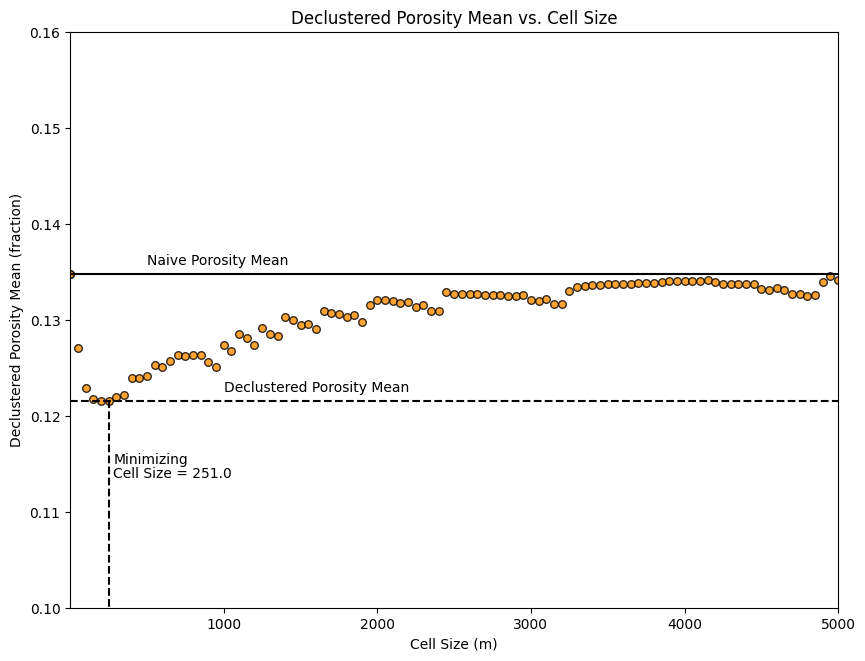

In [19]:
csize_min = cell_sizes[np.argmin(dmeans_cell)]                     # retrieve the minimizing cell size
smin = 0.1; smax = 0.16                                       # range of statistic on y axis, set to improve visualization

plt.subplot(111)
plt.scatter(cell_sizes,dmeans_cell, s=30, alpha = 0.8, edgecolors = "black", facecolors = 'darkorange')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Porosity Mean vs. Cell Size')
plt.plot([cmin,cmax],[por_mean,por_mean],color = 'black')
plt.plot([cmin,cmax],[por_dmean_cell,por_dmean_cell],color = 'black',ls='--')
plt.plot([csize_min,csize_min],[ymin,por_dmean_cell],color = 'black',linestyle='dashed')
plt.text(0.1*(cmax - cmin) + cmin, por_mean+0.001, r'Naive Porosity Mean')
plt.text(0.2*(cmax - cmin) + cmin, por_dmean_cell+0.001, r'Declustered Porosity Mean')
plt.text(csize_min+30,0.70 * (por_dmean_cell - smin) + smin, r'Minimizing')
plt.text(csize_min+30,0.63 * (por_dmean_cell - smin) + smin, r'Cell Size = ' + str(np.round(csize_min,1)))
plt.ylim([smin,smax])
plt.xlim(cmin,cmax)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

The cell size that minimizes the declustered mean is about 200m (estimated from the figure). This makes sense given our previous observation of the data spacing. 

The cell-based declustering weights integrate:

* the spatial arrangement of the data

### Kriging-based Declustering

Let's take the standard 2D kriging method and modify it

* we will sum the weights assigned to each spatial data

* calculate the weights as the normalized sum of the weights

Note, I extracted and modified the krige algorithm from GeostatsPy below to make a 2D kriging-based declustering method.

Let's assume a reasonable grid for kriging

* sufficient resolution to capture the spatial context of the data

* higher resolution results in more precision in the declustering weights

We will also assume simple kriging parameters.

* we want to limit the search to the range of correlation for computation efficiency

We will also assume a variogram

* very large range will result in equal weights

* no spatial correlation will result in equal weights

* in practice the variogram is infered from the data, for brevity here we assume a variogram model

In [20]:
# set grid parameters
xmin = 0.0; xmax = 1000.0                                     # range of x values
ymin = 0.0; ymax = 1000.0                                     # range of y values
xsiz = 10; ysiz = 10                                          # cell size
nx = 100; ny = 100                                            # number of cells
xmn = 5; ymn = 5                                              # grid origin, location center of lower left cell

# set kriging parameters
nxdis = 1; nydis = 1                                          # block kriging discretizations, 1 for point kriging
ndmin = 0; ndmax = 10                                         # minimum and maximum data for kriging 
radius = 100                                                  # maximum search distance
ktype = 0                                                     # kriging type, 0 - simple, 1 - ordinary
ivtype = 0                                                    # variable type, 0 - categorical, 1 - continuous
tmin = -999; tmax = 999;                                      # data trimming limits
skmean = 0.0

# define a variogram model
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100) # assume porosity variogram model

Let's run the kriging weight-based declustering method from GeostatsPy.

In [22]:
wts_kriging = geostats.declus_kriging(df,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean,vario)               # GeostatsPy's kriging weights-based declustering method

  Estimated   10000 blocks 
      average   0.08916381871701572  variance  0.001716058685217398


Add the weights to the original DataFrame.

In [23]:
df['Wts_kriging'] = wts_kriging                               # add weights to the sample data DataFrame
df.head()                                                     # preview to check the sample data DataFrame

,X,Y,Facies,Porosity,Perm,Wts_cell,Wts_kriging
0,100,900,1,0.115359,5.736104,3.423397,2.057241
1,100,800,1,0.136425,17.211462,1.254062,1.542512
2,100,600,1,0.135810,43.724752,1.037802,1.170267
3,100,500,0,0.094414,1.609942,1.112225,1.938401
4,100,100,0,0.113049,10.886001,1.176394,1.965010


Now let's add the distribution of the weights and the naive and declustered porosity distributions. You should see the histogram bars adjusted by the weights. Also note the change in the mean due to the weights. There is a significant change.

Porosity naive mean is 0.135.
Porosity declustered mean is 0.125.
Correction of 0.0742.

Summary statistics of the declustering weights:
DescribeResult(nobs=289, minmax=(-0.10447464028497654, 2.430154395153259), mean=1.0, variance=0.331769922663696, skewness=0.050890082070651294, kurtosis=-0.8375034409311843)


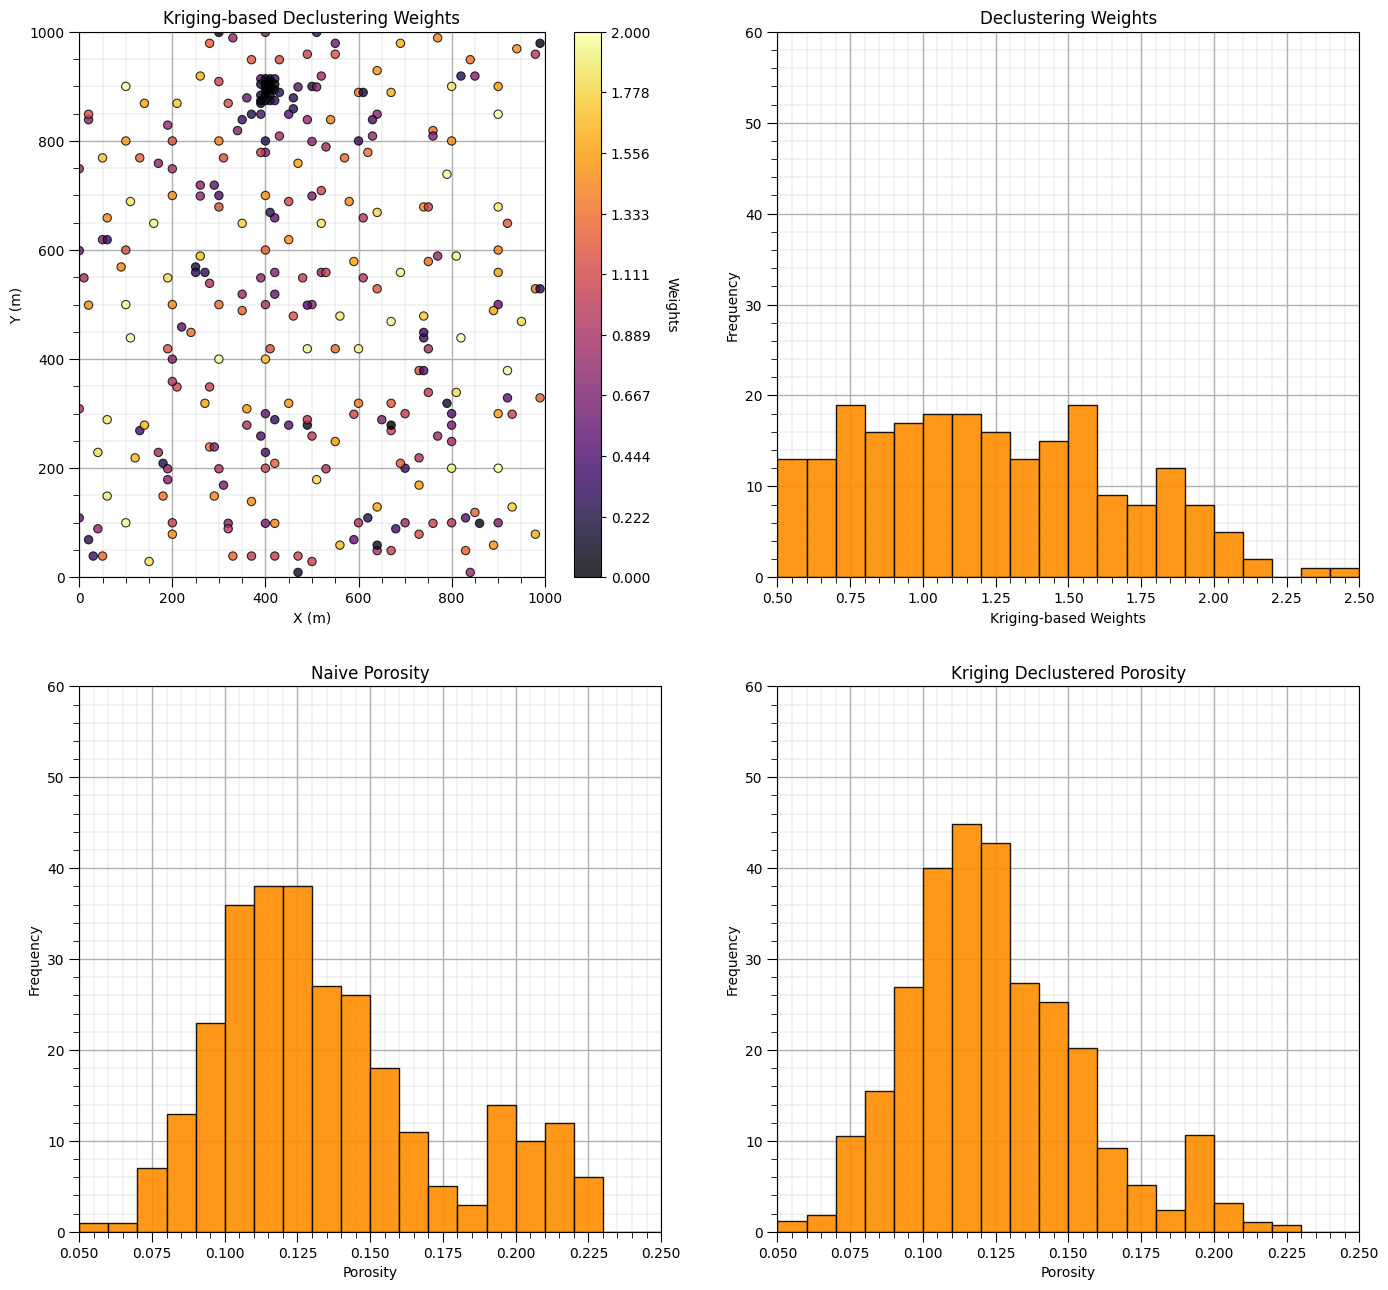

In [24]:
plt.subplot(221)
GSLIB.locmap_st(df,'X','Y','Wts_kriging',xmin,xmax,ymin,ymax,0.0,2.0,'Kriging-based Declustering Weights','X (m)','Y (m)','Weights',cmap); add_grid()

plt.subplot(222)
GSLIB.hist_st(df['Wts_kriging'],0.5,2.5,log=False,cumul=False,bins=20,weights=None,xlabel="Kriging-based Weights",title="Declustering Weights"); add_grid()
plt.ylim(0.0,60)

plt.subplot(223)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity",title="Naive Porosity"); add_grid()
plt.ylim(0.0,60)

plt.subplot(224)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=df['Wts_kriging'],xlabel="Porosity",title="Kriging Declustered Porosity"); add_grid()
plt.ylim(0.0,60)

por_mean = np.average(df['Porosity'].values)
por_dmean_kriging = np.average(df['Porosity'].values,weights=df['Wts_kriging'].values)

print('Porosity naive mean is ' + str(round(por_mean,3))+'.')
print('Porosity declustered mean is ' + str(round(por_dmean_kriging,3))+'.')
cor = (por_mean-por_dmean_kriging)/por_mean
print('Correction of ' + str(round(cor,4)) +'.')

print('\nSummary statistics of the declustering weights:')
print(stats.describe(wts_kriging))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2); plt.show()

Recall, the kriging-based declustering weights integrate:

* the spatial arrangement of the data

* the spatial continuity

* the study area of interest

### Polygonal Declustering

Let's calculate the polygons with a discret approximation on a regular grid:

* assign the nearest data value to each cell

* calculate the weights as the normalized sum of the weights (number of cells assigned to each datum)

Let's refine the grid for greater accuracy (with some increased run time, complexity is $O(n^2)$, and then run to calculate the polygonal weights and check the model by looking at the polygons and the data.

* WARNING: This may take 1-2 minutes to run.

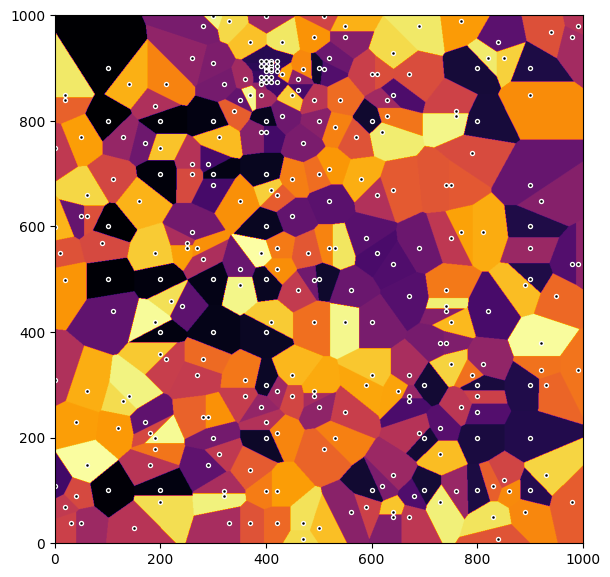

In [25]:
factor = 10                                                   # scaler for refining the grid to improved accuracy with longer run time, 1 minute on a modern desktop
pnx = nx * factor; pny = ny * factor; pxsiz = xsiz / factor; pysiz = ysiz / factor
pxmn = pxsiz / 2; pymn = pysiz / 2

wts_polygonal, polygons = geostats.polygonal_declus(df,'X','Y','Porosity',tmin,tmax,pnx,pxmn,pxsiz,pny,pymn,pysiz)

plt.subplot(111)
cs = plt.imshow(polygons,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = 0, vmax = len(df),cmap = plt.cm.inferno)
plt.scatter(df['X'].values,df['Y'].values,s=8,color='black',edgecolor='white')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Add the weights to the original DataFrame.

In [26]:
df['Wts_Polygonal'] = wts_polygonal                           # add weights to the sample data DataFrame
df.head()                                                     # preview to check the sample data DataFrame

,X,Y,Facies,Porosity,Perm,Wts_cell,Wts_kriging,Wts_Polygonal
0,100,900,1,0.115359,5.736104,3.423397,2.057241,4.988718
1,100,800,1,0.136425,17.211462,1.254062,1.542512,1.283449
2,100,600,1,0.135810,43.724752,1.037802,1.170267,1.039822
3,100,500,0,0.094414,1.609942,1.112225,1.938401,1.675044
4,100,100,0,0.113049,10.886001,1.176394,1.965010,1.657993


Now let's add the distribution of the weights and the naive and declustered porosity distributions. You should see the histogram bars adjusted by the weights. Also note the change in the mean due to the weights. There is a significant change.

Porosity naive mean is 0.135.
Porosity polygonal declustering mean is 0.122.
Correction of 0.0939.

Summary statistics of the declustering weights:
DescribeResult(nobs=289, minmax=(0.012138, 4.9887179999999995), mean=1.0, variance=0.44681492157900693, skewness=1.8060785761144078, kurtosis=7.229681691580751)


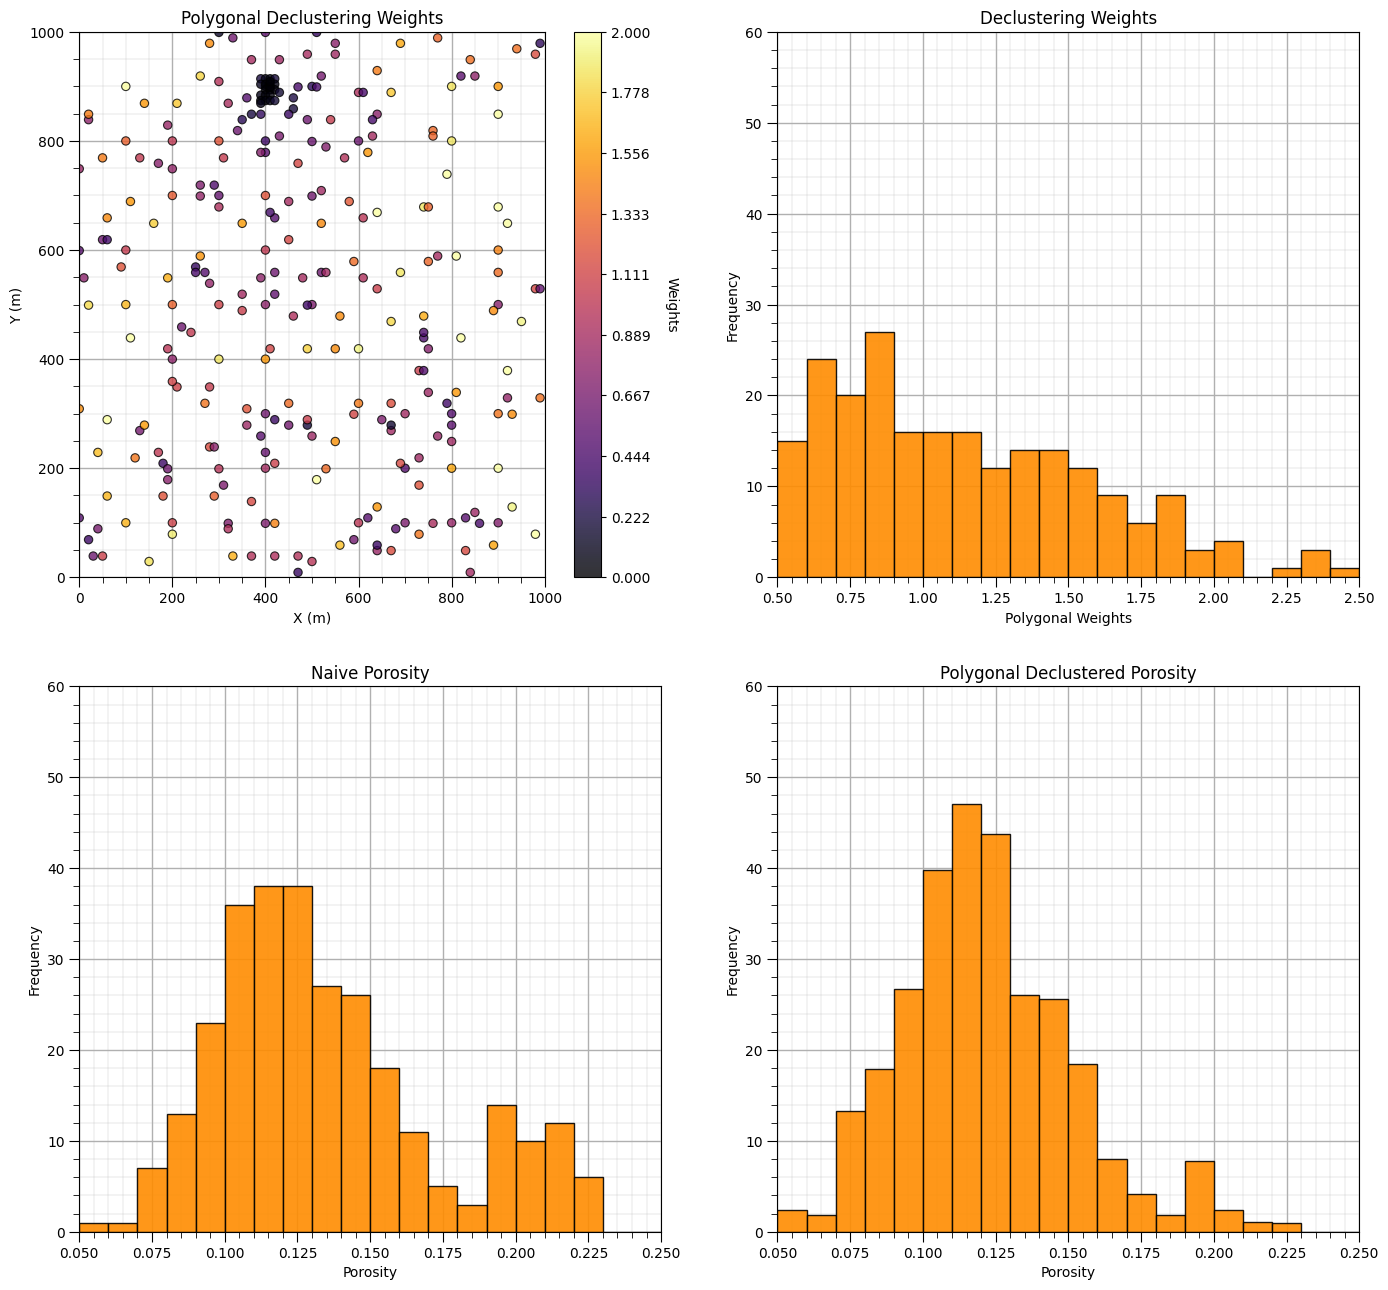

In [27]:
plt.subplot(221)
GSLIB.locmap_st(df,'X','Y','Wts_Polygonal',xmin,xmax,ymin,ymax,0.0,2.0,'Polygonal Declustering Weights','X (m)','Y (m)','Weights',cmap); add_grid()

plt.subplot(222)
GSLIB.hist_st(df['Wts_Polygonal'],0.5,2.5,log=False,cumul=False,bins=20,weights=None,xlabel="Polygonal Weights",title="Declustering Weights"); add_grid()
plt.ylim(0.0,60)

plt.subplot(223)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity",title="Naive Porosity"); add_grid()
plt.ylim(0.0,60)

plt.subplot(224)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=df['Wts_Polygonal'],xlabel="Porosity",title="Polygonal Declustered Porosity"); add_grid()
plt.ylim(0.0,60)

por_mean = np.average(df['Porosity'].values)
por_dmean_polygonal = np.average(df['Porosity'].values,weights=df['Wts_Polygonal'].values)

print('Porosity naive mean is ' + str(round(por_mean,3))+'.')
print('Porosity polygonal declustering mean is ' + str(round(por_dmean_polygonal,3))+'.')
cor = (por_mean-por_dmean_polygonal)/por_mean
print('Correction of ' + str(round(cor,4)) +'.')

print('\nSummary statistics of the declustering weights:')
print(stats.describe(wts_polygonal))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2); plt.show()

The polygonal declustering weights integrate:

* the spatial arrangement of the data

* the study area of interest

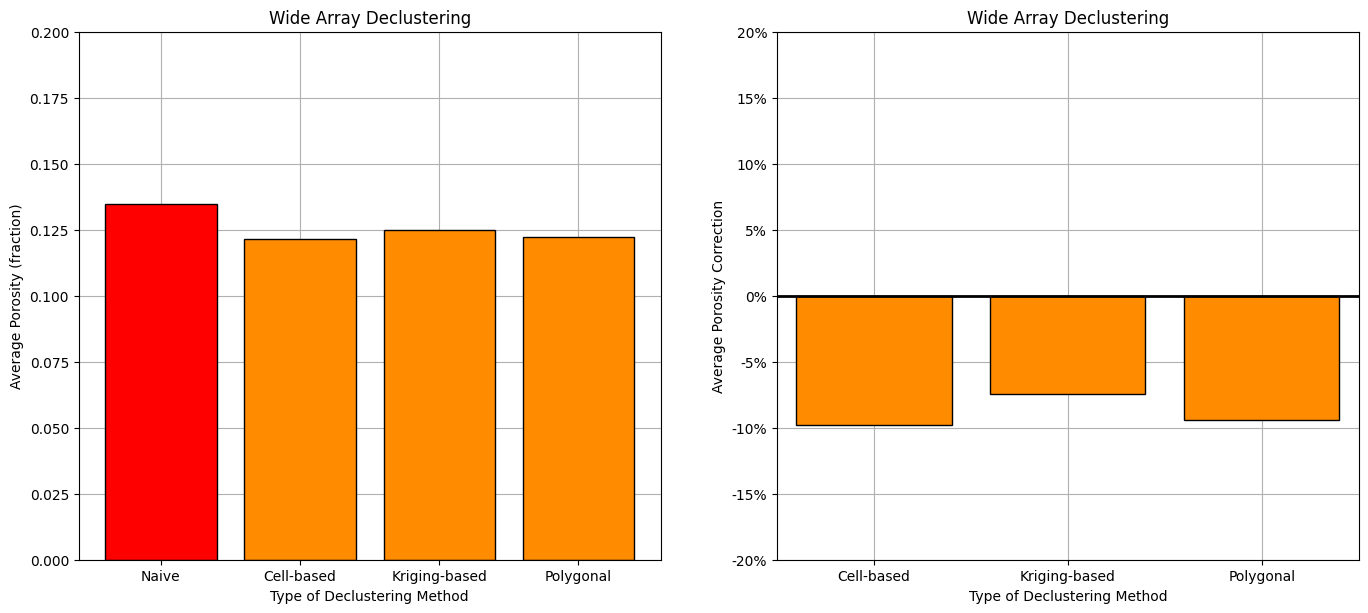

In [30]:
plt.subplot(121)
bar = plt.bar(['Naive','Cell-based','Kriging-based','Polygonal'],[por_mean,por_dmean_cell,por_dmean_kriging,por_dmean_polygonal],color='darkorange',edgecolor='black')
bar[0].set_color('red'); bar[0].set_edgecolor('black')
plt.ylim([0,0.20]); plt.grid(True); plt.title('Wide Array Declustering'); plt.ylabel('Average Porosity (fraction)'); plt.xlabel('Type of Declustering Method')

plt.subplot(122)
plt.bar(['Cell-based','Kriging-based','Polygonal'],[(por_dmean_cell-por_mean)/por_mean*100,(por_dmean_kriging-por_mean)/por_mean*100,(por_dmean_polygonal-por_mean)/por_mean*100],color='darkorange',edgecolor='black')
plt.plot([-0.5,2.5],[0,0],color='black',lw=2); plt.xlim([-0.5,2.5])
plt.ylim([-20,20]); plt.grid(True); plt.title('Wide Array Declustering'); plt.ylabel('Average Porosity Correction'); plt.xlabel('Type of Declustering Method')
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(xticks)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

We have good agreement between the 3 declustering methods, some reasons for this?:

* the data covers the entire AOI - there is not a significant issue with boundary assumption

* the spatial continuity, variogram model is isotropic - there is a significant impact of spatial continuity on the results

* the declustered mean vs. cell size plot is clear, i.e., the minimizing cell size is clear - there is not a significant uncertainty on best cell size

#### Comments

This was a basic demonstration of cell-based, polygonal-based and kriging-based spatial data declustering for robust correction of sampling bias. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  
  